In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import weighted_mode
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler

import random
import os

from timeit import default_timer as timer 
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import resample

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import pathlib
#PROJECT_PATH = pathlib.Path(__file__).parent.parent.resolve()
DEVELOPMENT_FILE = "../Files/metadata/development.csv"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [5]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [6]:
# Assuming dataset.data() returns your numpy array and classes.label_to_class converts labels to classes
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

# Take only the melspect feature
X_new = X[:, 12:76, :]

In [7]:
# Load the data into a DataFrame (replace this with your data loading code)
data = pd.read_csv(DEVELOPMENT_FILE)

# Get unique speaker IDs
speaker_ids = data['speaker_id'].unique()

# Split speaker IDs into train, test, and dev sets
train_speaker_ids, test_dev_speaker_ids = train_test_split(speaker_ids, test_size=0.2, random_state=42)
test_speaker_ids, dev_speaker_ids = train_test_split(test_dev_speaker_ids, test_size=0.5, random_state=42)

# Filter data into train, test, and dev sets based on speaker IDs
train_data = data[data['speaker_id'].isin(train_speaker_ids)]
test_data = data[data['speaker_id'].isin(test_speaker_ids)]
dev_data = data[data['speaker_id'].isin(dev_speaker_ids)]

# Optionally, shuffle the train, test, and dev DataFrames
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
dev_data = dev_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Oversample specific words in the training data
words_to_oversample = ['Alarm', 'aus', 'Ofen']  # List of words to oversample
oversampled_data = pd.concat([resample(train_data[train_data['word'].isin(words_to_oversample)], 
                                       replace=True,  # With replacement
                                       n_samples=3000,  # Adjust oversampling size as needed
                                       random_state=42),  # Set random state for reproducibility
                              train_data])

# Shuffle the oversampled data
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Get the indices of rows corresponding to speaker IDs in train, test, and dev sets
# train_indices = oversampled_data['id'].values
train_indices = train_data['id'].values
test_indices = test_data['id'].values
dev_indices = dev_data['id'].values

# Select the corresponding columns of X for train, test, and dev sets
X_train = X_new[train_indices, :, :]
X_test = X_new[test_indices, :, :]
X_dev = X_new[dev_indices, :, :]

# Split labels (y) along with features (X)
y_train = y[train_indices]
y_test = y[test_indices]
y_dev = y[dev_indices]

In [10]:
# Check if oversampling worked as expected
print(oversampled_data['word'].value_counts())

other          3520
aus            2640
Ofen           2632
Alarm          2595
Schraube       1627
Fernseher      1626
Lüftung        1626
Leitung        1626
nicht          1625
Licht          1624
wunderbar      1624
Haus           1622
Radio          1622
an             1621
warm           1620
kann           1620
Brötchen       1620
Spiegel        1620
offen          1619
Staubsauger    1619
Heizung        1618
Name: word, dtype: int64


In [11]:
print(train_data['word'].value_counts())
print(train_data['word'].value_counts().sum())

other          3520
Schraube       1627
Fernseher      1626
Leitung        1626
Lüftung        1626
nicht          1625
Ofen           1624
wunderbar      1624
Licht          1624
Haus           1622
Radio          1622
Alarm          1622
aus            1621
an             1621
Brötchen       1620
Spiegel        1620
kann           1620
warm           1620
offen          1619
Staubsauger    1619
Heizung        1618
Name: word, dtype: int64
35966


In [12]:
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_dev.shape)

Train set shape: (35966, 64, 44)
Test set shape: (4571, 64, 44)
Validation set shape: (4759, 64, 44)


In [13]:
# Assuming X_train, X_test, y_train, y_test are numpy arrays
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # y_train contains integer labels
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # y_test contains integer labels
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)    # y_dev contains integer labels

X_train_tensor = X_train_tensor.unsqueeze(dim=1)
X_test_tensor = X_test_tensor.unsqueeze(dim=1)
X_dev_tensor = X_dev_tensor.unsqueeze(dim=1)

# Create training and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

In [14]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    drop_last=True,
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

dev_dataloader = DataLoader(dev_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of dev dataloader: {len(dev_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1123 batches of 32
Length of test dataloader: 142 batches of 32
Length of dev dataloader: 148 batches of 32


In [15]:
class AudioClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        # Reshape the tensor to have a two-dimensional shape
        x = x.view(-1, 128 * 4 * 2)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [16]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Accumulate the accuracy

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient computation
        for batch, (X, y) in enumerate(data_loader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()  # Accumulate the loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # Accumulate the accuracy

        # Calculate loss and accuracy per epoch and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        return test_loss, test_acc


In [17]:
# Initialize the model
model = AudioClassifierCNN(len(classes.CLASSES))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def train_model_with_lr(lr, train_dataloader, test_dataloader, model, loss_fn, accuracy_fn, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    torch.manual_seed(42)

    # Measure time
    train_time_start_model = timer()

    delta = 1e-2
    patience = 5
    best_test_loss = float('inf')
    best_epoch = 0
    counter = 0

    # Train and test model 
    epochs = 20
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")

        train_loss, train_acc = train_step(data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

        test_loss, test_acc = test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        # Check for early stopping
        if test_loss < best_test_loss - delta:
            best_test_loss = test_loss
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping. No improvement since epoch {best_epoch}.')
                break
    train_time_end_model = timer()
    total_train_time_model = print_train_time(start=train_time_start_model,
                                              end=train_time_end_model,
                                              device=device)
    return best_test_loss, total_train_time_model, model

# List of learning rates to try
learning_rates = [1e-5, 1e-4, 1e-3]

results = {}
os.makedirs('saved_models', exist_ok=True)

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Re-initialize the model for each learning rate
    model = AudioClassifierCNN(len(classes.CLASSES))
    best_loss, train_time, trained_model = train_model_with_lr(lr, train_dataloader, test_dataloader, model, loss_fn, accuracy_fn, device)
    
    # Save the trained model
    model_path = f'saved_models/model_lr_{lr}.pth'
    torch.save(trained_model.state_dict(), model_path)
    
    results[lr] = {'best_loss': best_loss, 'train_time': train_time, 'model_path': model_path}

# Display results
for lr, result in results.items():
    print(f"Learning Rate: {lr} | Best Test Loss: {result['best_loss']:.5f} | Training Time: {result['train_time']} | Model Path: {result['model_path']}")



Training with learning rate: 1e-05


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.77210 | Train accuracy: 54.10%
Test loss: 1.66033 | Test accuracy: 55.46%

Epoch: 1
---------
Train loss: 1.48379 | Train accuracy: 55.22%
Test loss: 1.21952 | Test accuracy: 57.90%

Epoch: 2
---------
Train loss: 1.05884 | Train accuracy: 62.61%
Test loss: 0.95668 | Test accuracy: 64.17%

Epoch: 3
---------
Train loss: 0.87417 | Train accuracy: 69.92%
Test loss: 0.82962 | Test accuracy: 72.65%

Epoch: 4
---------
Train loss: 0.77292 | Train accuracy: 73.18%
Test loss: 0.75666 | Test accuracy: 74.43%

Epoch: 5
---------
Train loss: 0.70201 | Train accuracy: 75.59%
Test loss: 0.71339 | Test accuracy: 75.79%

Epoch: 6
---------
Train loss: 0.64767 | Train accuracy: 77.25%
Test loss: 0.65285 | Test accuracy: 76.25%

Epoch: 7
---------
Train loss: 0.60299 | Train accuracy: 78.89%
Test loss: 0.61773 | Test accuracy: 77.66%

Epoch: 8
---------
Train loss: 0.56895 | Train accuracy: 79.99%
Test loss: 0.57884 | Test accuracy: 79.14%

Epoch: 9
---------
Train los

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.17614 | Train accuracy: 63.62%
Test loss: 0.65335 | Test accuracy: 77.24%

Epoch: 1
---------
Train loss: 0.49846 | Train accuracy: 82.16%
Test loss: 0.43704 | Test accuracy: 83.91%

Epoch: 2
---------
Train loss: 0.34819 | Train accuracy: 87.85%
Test loss: 0.36918 | Test accuracy: 86.38%

Epoch: 3
---------
Train loss: 0.27792 | Train accuracy: 90.38%
Test loss: 0.32233 | Test accuracy: 87.63%

Epoch: 4
---------
Train loss: 0.23206 | Train accuracy: 91.87%
Test loss: 0.28784 | Test accuracy: 89.85%

Epoch: 5
---------
Train loss: 0.20209 | Train accuracy: 93.12%
Test loss: 0.24800 | Test accuracy: 91.02%

Epoch: 6
---------
Train loss: 0.18039 | Train accuracy: 93.77%
Test loss: 0.26115 | Test accuracy: 90.82%

Epoch: 7
---------
Train loss: 0.16093 | Train accuracy: 94.67%
Test loss: 0.23944 | Test accuracy: 91.99%

Epoch: 8
---------
Train loss: 0.14733 | Train accuracy: 95.00%
Test loss: 0.22490 | Test accuracy: 92.21%

Epoch: 9
---------
Train los

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.68761 | Train accuracy: 78.09%
Test loss: 0.31532 | Test accuracy: 88.95%

Epoch: 1
---------
Train loss: 0.21698 | Train accuracy: 92.53%
Test loss: 0.23045 | Test accuracy: 91.73%

Epoch: 2
---------
Train loss: 0.15879 | Train accuracy: 94.57%
Test loss: 0.24255 | Test accuracy: 91.11%

Epoch: 3
---------
Train loss: 0.13297 | Train accuracy: 95.31%
Test loss: 0.25022 | Test accuracy: 90.69%

Epoch: 4
---------
Train loss: 0.11234 | Train accuracy: 96.01%
Test loss: 0.22736 | Test accuracy: 92.63%

Epoch: 5
---------
Train loss: 0.09991 | Train accuracy: 96.40%
Test loss: 0.26076 | Test accuracy: 91.97%

Epoch: 6
---------
Train loss: 0.08956 | Train accuracy: 96.77%
Test loss: 0.25349 | Test accuracy: 92.45%

Early stopping. No improvement since epoch 1.
Train time on cuda: 34.474 seconds
Learning Rate: 1e-05 | Best Test Loss: 0.41923 | Training Time: 101.81016819999786 | Model Path: saved_models/model_lr_1e-05.pth
Learning Rate: 0.0001 | Best Test 

In [19]:
# To load and use a saved model later
def load_model(model_class, model_path, device, num_classes):
    model = model_class(num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Make predictions with all saved models
def make_predictions_with_all_models(model_class, model_paths, num_classes, dataloader, device):
    for lr, result in model_paths.items():
        model_path = result['model_path']
        print(f"\nMaking predictions with model trained with learning rate: {lr}")
        
        model = load_model(model_class, model_path, device, num_classes)
        model.eval()
        
        y_preds = []
        y_true = []
        
        with torch.inference_mode():
            for X, y in tqdm(dataloader, desc="Making predictions"):
                # Send data and targets to target device
                X, y = X.to(device), y.to(device)
                # Do the forward pass
                y_logit = model(X)
                # Turn predictions from logits -> prediction probabilities -> predictions labels
                y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
                # Put predictions on CPU for evaluation
                y_preds.append(y_pred.cpu())
                y_true.append(y.cpu())
        
        # Concatenate list of predictions into a tensor
        y_pred_tensor = torch.cat(y_preds)
        y_true_tensor = torch.cat(y_true)
        
        # Calculate and print any metrics
        print(f"Predictions for model with learning rate {lr}:")
        accuracy = (y_pred_tensor == y_true_tensor).sum().item() / len(y_true_tensor)
        print(f"Accuracy: {accuracy:.2f}%")
        
        # Save predictions
        torch.save({'y_pred': y_pred_tensor, 'y_true': y_true_tensor}, f'saved_predictions/predictions_lr_{lr}.pth')

In [20]:
# Ensure directory for predictions exists
os.makedirs('saved_predictions', exist_ok=True)

make_predictions_with_all_models(AudioClassifierCNN, results, len(classes.CLASSES), dev_dataloader, device)


Making predictions with model trained with learning rate: 1e-05


Making predictions:   0%|          | 0/148 [00:00<?, ?it/s]

Predictions for model with learning rate 1e-05:
Accuracy: 0.84%

Making predictions with model trained with learning rate: 0.0001


Making predictions:   0%|          | 0/148 [00:00<?, ?it/s]

Predictions for model with learning rate 0.0001:
Accuracy: 0.93%

Making predictions with model trained with learning rate: 0.001


Making predictions:   0%|          | 0/148 [00:00<?, ?it/s]

Predictions for model with learning rate 0.001:
Accuracy: 0.91%


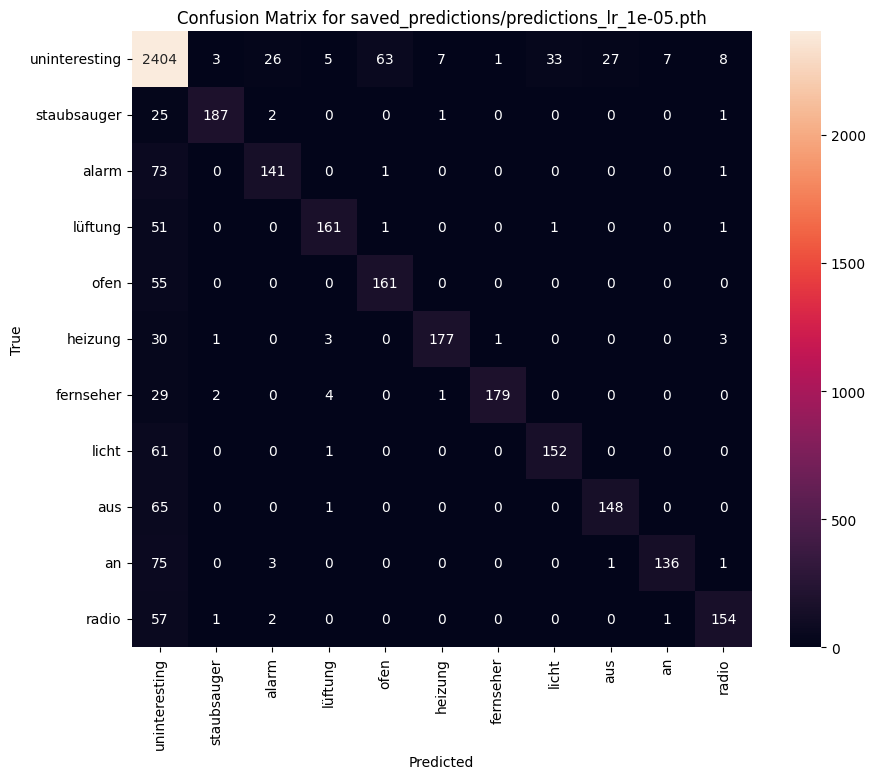

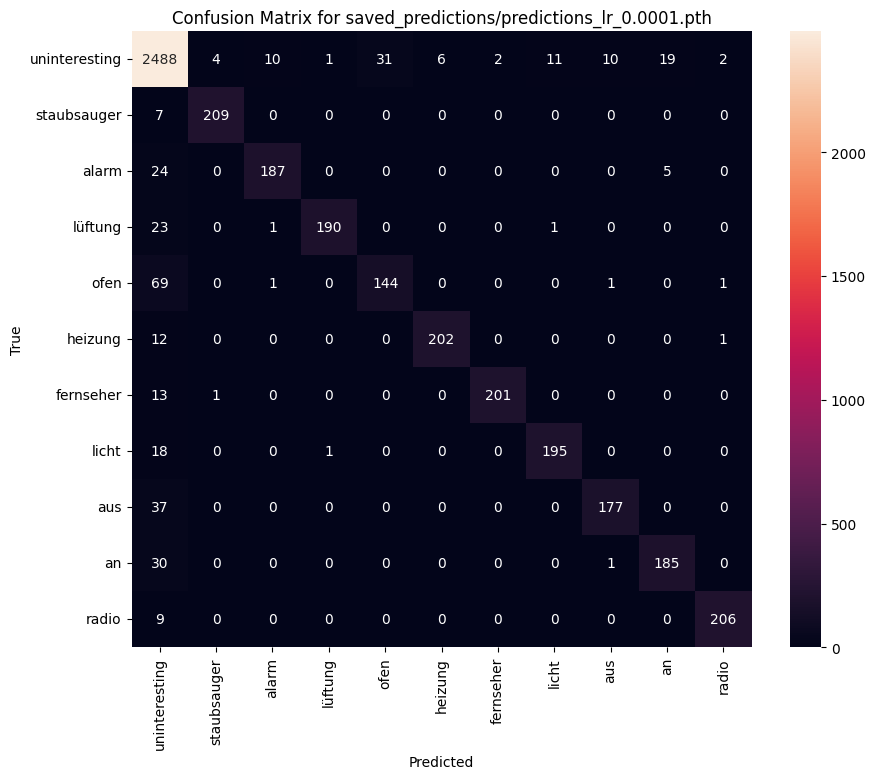

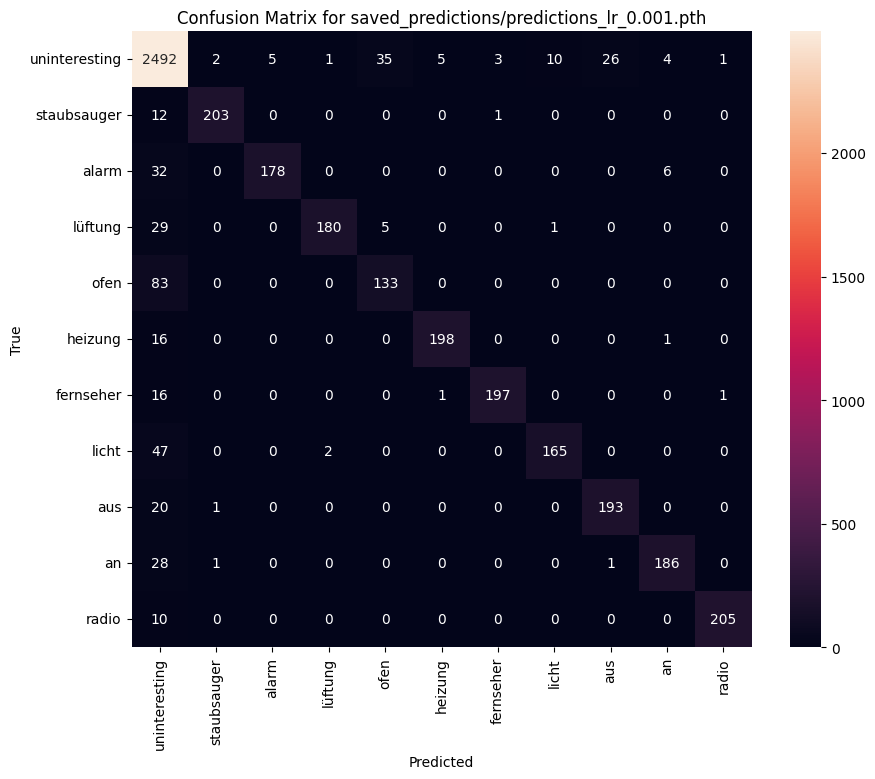

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes, prediction_file):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix for {}".format(prediction_file))
    plt.show()

prediction_files = ['saved_predictions/predictions_lr_1e-05.pth', 'saved_predictions/predictions_lr_0.0001.pth', 'saved_predictions/predictions_lr_0.001.pth']
plot_classes = [key for key, _ in classes.CLASSES.items()]  # Extracting only the keys

for prediction_file in prediction_files:
    saved_data = torch.load(prediction_file)
    y_true = saved_data['y_true'].numpy()
    y_pred = saved_data['y_pred'].numpy()
    
    plot_confusion_matrix(y_true, y_pred, plot_classes, prediction_file)